In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import h5py
from pathlib import Path
import os
import sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')
from filepaths import filepath_from_ml_artifacts_uri
from analysis.iclr.plotting import settings, fig_size, cb_line_cycler, cb_line_cycler_solid, cb_marker_cycler, savefig
from plot_hdf5_dataset import plot_dataset
from iclr_paper_path import get_paper_path
import matplotlib
settings()
import matplotlib.pyplot as plt

# beta 0.01
# path_dataset = filepath_from_ml_artifacts_uri('mlflow-artifacts:/829789035554334690/9e712d90248a4475b3bd7f1ff88f727e/artifacts/dataset.hdf5')
# beta 0.1
path_dataset = filepath_from_ml_artifacts_uri('mlflow-artifacts:/829789035554334690/d4ab1a5174054e12a8767e9c46d4827a/artifacts/dataset.hdf5')
# beta 0.1 rrcos steam 
path_dataset = filepath_from_ml_artifacts_uri('mlflow-artifacts:/765349530991563084/b0b0669ff51c4ee5b05f203dc1d827c6/artifacts/dataset.hdf5')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset = h5py.File(path_dataset, 'r')
print(dataset.keys())

<KeysViewHDF5 ['common_test', 'common_validation', 'controls_names', 'outputs_names', 'states_der_names', 'states_names', 'test', 'time', 'train', 'validation']>


In [4]:
dataset['common_test'].keys()

<KeysViewHDF5 ['controls', 'kl_lat_controls', 'kl_lat_controls_per_dim', 'kl_lat_parameters', 'kl_lat_state_0', 'kl_lat_state_0_per_dim', 'kl_lat_states', 'kl_lat_states_per_dim', 'kl_loss', 'lat_controls_logvar', 'lat_controls_mu', 'lat_dim_controls_populated', 'lat_dim_parameters_populated', 'lat_dim_state_0_populated', 'lat_dim_states_populated', 'lat_state_0_logvar', 'lat_state_0_mu', 'lat_states_logvar', 'lat_states_mu', 'loss', 'ode_calls_forward', 'outputs', 'outputs_hat', 'reconstruction_loss', 'reconstruction_loss_outputs', 'reconstruction_loss_state_0', 'reconstruction_loss_states', 'rmse_outputs', 'rmse_state_0', 'rmse_states', 'states', 'states_der', 'states_hat', 'time_odeint', 'time_outputs']>

In [5]:
dataset_type = 'common_test'
# kl_lat_state_0_per_dim = dataset[dataset_type]['kl_lat_state_0_per_dim'][:]
lat_states_mu = dataset[dataset_type]['lat_states_mu'][:]
lat_states_sigma = dataset[dataset_type]['lat_states_logvar'][:]
kl_lat_states = dataset[dataset_type]['kl_lat_states_per_dim'][:]
# states = dataset[dataset_type]['states'][:]
# states_hat = dataset[dataset_type]['states_hat'][:]
# time = dataset['time'][:]

# convert logvar to sigma
lat_states_sigma = np.exp(lat_states_sigma / 2)

# get populated states
kl_mean = np.mean(kl_lat_states, axis=(0,2))
# get idx for sorting
kl_mean_idx = np.flip(np.argsort(kl_mean))
print(kl_mean_idx)
print(kl_mean[kl_mean_idx])

[  3  76  25  93  98  64  94  17  53 117  68 122  61 107  86  52 124  24
   1  22  16  73  37  96  26  81  28  31  15 114  97  92  21   9 104  69
  47  90  14  41 120  65  56  66  19  95  48  45 112  99 110  34  62  36
  59 103  89  11 119  29  18 102  87  70  63  83  23  54  75   6  27  35
 118   2  80  71 105 115   5 100 101   7 116 127  10 125  60 113  55 106
  40  88  30 111  50   0  85   8 126  46  33  43  72  84  38  79  74  44
  91  77  20 109  82  13  58  67  39   4  51  12 123  42 121  49  78 108
  57  32]
[3.91411638e+00 3.02035022e+00 1.59468567e+00 9.42948818e-01
 7.11627126e-01 3.41704875e-01 8.40433165e-02 7.93079585e-02
 7.73275942e-02 6.51898682e-02 6.01237416e-02 5.68378232e-02
 4.01309989e-02 3.81848887e-02 3.71413827e-02 3.43841091e-02
 3.41996253e-02 3.25598456e-02 3.16532813e-02 2.87764613e-02
 2.84206327e-02 2.77310219e-02 2.52956282e-02 2.46995986e-02
 2.43998226e-02 2.21301876e-02 2.02839971e-02 1.96547899e-02
 1.93637647e-02 1.77368633e-02 1.70634296e-02 1.6570

0.03632979281246662
0.06088425870984793
0.04286563489586115
0.09411689266562462
0.1334310956299305
0.3500000536441803
finding path that contains "code", then going up one level to find "LaTeX"
e:\projects\balanced_neural_odes_internal\code\python\analysis\iclr
e:\projects\balanced_neural_odes_internal\code\python\analysis
e:\projects\balanced_neural_odes_internal\code\python
e:\projects\balanced_neural_odes_internal\code
e:\projects\balanced_neural_odes_internal
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\BNODE\sigma_mu_hist.png
E:\projects\balanced_neural_odes_internal\LaTeX\ICLR 2025 Template\figures\BNODE\sigma_mu_hist.svg


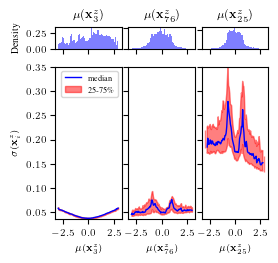

In [6]:
n_first_states = 3

fig, ax = plt.subplots(2, n_first_states, sharex=True, figsize=fig_size(2.5, n_figs_per_width=2), gridspec_kw={'height_ratios': [0.15, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.2)

_min_sigma = 100
_max_sigma = -100
mu_min = -3
mu_max = 3

for ax_idx in range(0,n_first_states):
    n_most_populated = ax_idx
    bins_mu = np.linspace(mu_min, mu_max, 100)
    # get histogram of mu
    mu_reshaped = lat_states_mu[:,kl_mean_idx[n_most_populated],:].reshape((-1))
    sigma_reshaped = lat_states_sigma[:,kl_mean_idx[n_most_populated],:].reshape((-1))
    ax[0,ax_idx].hist(mu_reshaped, bins = bins_mu, alpha=0.5, label='mu', color='b', density=True)
    # ax.hist(sigma_reshaped, bins=100, alpha=0.5, label='sigma', color='r')

    # assign state idx to bins 
    state_in_bin_idx = np.digitize(mu_reshaped, bins_mu)

    sigma_bin = []
    sigma_bin_mean = []
    sigma_bin_std = []
    sigma_bin_25 = []
    sigma_bin_75 = []
    sigma_bin_50 = []

    for i, bin in enumerate(bins_mu):
        idx = np.where(state_in_bin_idx == i)
        _sigmas_in_bin = sigma_reshaped[idx]
        sigma_bin.append(_sigmas_in_bin)
        if _sigmas_in_bin.size < 100:
            sigma_bin_mean.append(float('nan'))
            sigma_bin_std.append(float('nan'))
            sigma_bin_25.append(float('nan'))
            sigma_bin_75.append(float('nan'))
            sigma_bin_50.append(float('nan'))
        else:
            sigma_bin_mean.append(np.mean(_sigmas_in_bin))
            sigma_bin_std.append(np.std(_sigmas_in_bin))
            sigma_bin_25.append(np.percentile(_sigmas_in_bin, 25))
            sigma_bin_75.append(np.percentile(_sigmas_in_bin, 75))
            sigma_bin_50.append(np.percentile(_sigmas_in_bin, 50))

    ax[1,ax_idx].plot(bins_mu, sigma_bin_50, label='median', color='b', linewidth=1.0)
    ax[1,ax_idx].fill_between(bins_mu, sigma_bin_25, sigma_bin_75, alpha=0.5, label='25-75\%', color='r')
    # ax[1,ax_idx].set_xlim([-2, 2])
    ax[1,ax_idx].set_xlabel(r'$\mu(\mathbf{x}_{' +str(kl_mean_idx[n_most_populated]) + '}^z)$')
    if ax_idx > 0:
        ax[1,ax_idx].set_yticklabels([])
        ax[0,ax_idx].set_yticklabels([])

    _min_sigma = min(_min_sigma, np.nanmin(sigma_bin_25))
    print(np.nanmin(sigma_bin_25))
    _max_sigma = max(_max_sigma, np.nanmax(sigma_bin_75))
    print(np.nanmax(sigma_bin_75))

    # ax[0,ax_idx].set_title(r'\noindent Latent state \\' + str(kl_mean_idx[n_most_populated]) + r' $\mu(\mathbf{x}^z)$')
    ax[0,ax_idx].set_title(r'$\mu(\mathbf{x}_{' +str(kl_mean_idx[n_most_populated]) + '}^z)$')

ax[0,0].set_ylabel('Density')
ax[1,0].set_ylabel(r'$\sigma(\mathbf{x}_i^z)$', fontsize=7)

ax[1,0].legend(fontsize=6)


for i in range(0,n_first_states):
    # set y-axis limits
    ax[1,i].set_ylim([_min_sigma, _max_sigma])

savefig(fig, get_paper_path('BNODE', 'sigma_mu_hist'))
    